In [2]:
import pandas as pd
import numpy as np
import sys

import warnings
import math

df=pd.read_csv('../data/data.csv.gz', compression='gzip', sep=',')
df['timestamp'] = pd.to_datetime(df['time_stamp'], format="%Y-%m-%d %H:%M:%S").dt.tz_convert('Europe/Stockholm')


In [3]:
stock_delta = df['stock_id'] - df['stock_id'].shift()
time_delta = (df['timestamp'] - df['timestamp'].shift()).fillna(10000).dt.total_seconds()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  


In [4]:
stock_split_index=df.index[stock_delta!=0].tolist()
stock_split_index.append(len(df))

In [5]:
day_split_index=df.index[abs(time_delta)>36000].tolist()
day_split_index.insert(0, 0)
day_split_index.append(len(df))

In [6]:
stock_id_list = df['stock_id'].unique().tolist()

In [7]:
current_stock_index = 0
time_series_list = []
time_series_all_list = []
for i in range(len(day_split_index) - 1):
    start_index = day_split_index[i]
    end_index = day_split_index[i + 1]
    day_time_series = df.iloc[start_index:end_index]
    time_series_list.append(day_time_series)
    if end_index == stock_split_index[current_stock_index + 1]:
        print("finished stock: {}, got {} time series".format(current_stock_index, len(time_series_list)))
        time_series_all_list.append(time_series_list)
        time_series_list = []
        current_stock_index += 1

finished stock: 0, got 52 time series
finished stock: 1, got 52 time series
finished stock: 2, got 52 time series
finished stock: 3, got 52 time series
finished stock: 4, got 52 time series
finished stock: 5, got 52 time series
finished stock: 6, got 52 time series
finished stock: 7, got 52 time series
finished stock: 8, got 52 time series
finished stock: 9, got 52 time series
finished stock: 10, got 52 time series
finished stock: 11, got 52 time series
finished stock: 12, got 52 time series
finished stock: 13, got 52 time series
finished stock: 14, got 52 time series
finished stock: 15, got 52 time series
finished stock: 16, got 52 time series
finished stock: 17, got 52 time series
finished stock: 18, got 52 time series
finished stock: 19, got 52 time series
finished stock: 20, got 52 time series
finished stock: 21, got 52 time series
finished stock: 22, got 52 time series
finished stock: 23, got 52 time series
finished stock: 24, got 52 time series
finished stock: 25, got 52 time ser

In [8]:
for stock_id in range(len(time_series_all_list)):
    print("handling stock_id: {}".format(stock_id))
    for day_id in range(len(time_series_all_list[stock_id])):
        df = time_series_all_list[stock_id][day_id]
        df['ema_10'] = df['last'].ewm(span=10, adjust=False).mean()
        df['ema_20'] = df['last'].ewm(span=20, adjust=False).mean()
        df['diff_ema_10']=df['ema_10'].diff()[1:]/df['ema_10']
        df['diff_ema_20']=df['ema_20'].diff()[1:]/df['ema_20']
        df['value_ema_10_beta_99'] = 0
        df['value_ema_20_beta_99'] = 0
        df['value_ema_10_beta_98'] = 0
        df['value_ema_20_beta_98'] = 0
        for iter_id in range(10):
            df['value_ema_10_beta_99'] = df['diff_ema_10'].shift(-1) + \
                0.99 * df['value_ema_10_beta_99'].shift(-1)
            df['value_ema_10_beta_98'] = df['diff_ema_10'].shift(-1) + \
                0.98 * df['value_ema_10_beta_98'].shift(-1)
            df['value_ema_20_beta_99'] = df['diff_ema_20'].shift(-1) + \
                0.99 * df['value_ema_20_beta_99'].shift(-1)
            df['value_ema_20_beta_98'] = df['diff_ema_20'].shift(-1) + \
                0.98 * df['value_ema_20_beta_98'].shift(-1)

handling stock_id: 0
handling stock_id: 1
handling stock_id: 2
handling stock_id: 3
handling stock_id: 4
handling stock_id: 5
handling stock_id: 6
handling stock_id: 7
handling stock_id: 8
handling stock_id: 9
handling stock_id: 10
handling stock_id: 11
handling stock_id: 12
handling stock_id: 13
handling stock_id: 14
handling stock_id: 15
handling stock_id: 16
handling stock_id: 17
handling stock_id: 18
handling stock_id: 19
handling stock_id: 20
handling stock_id: 21
handling stock_id: 22
handling stock_id: 23
handling stock_id: 24
handling stock_id: 25
handling stock_id: 26
handling stock_id: 27
handling stock_id: 28
handling stock_id: 29


In [10]:
%matplotlib notebook
from ipywidgets import *

widgets.IntSlider(min=0,max=len(time_series_all_list[0]) - 1,step=1,value=10)

@interact(stock_id=widgets.IntSlider(min=0,max=len(time_series_all_list) - 1,step=1,value=10), day_id = widgets.IntSlider(min=0,max=len(time_series_all_list[0]) - 1,step=1,value=10))
def plot(stock_id, day_id ):
    time_series_all_list[stock_id][day_id].plot(x='timestamp', y=['last','ema_20'])
    time_series_all_list[stock_id][day_id].plot(x='timestamp', y=['value_ema_20_beta_99'])

In [47]:
columns = ['timestamp','last']
print(stock_id_list)
df1 = time_series_all_list[0][0][columns].rename({'last': 'last_' + str(stock_id_list[0])}, axis=1)
df2 = time_series_all_list[1][0][columns].rename({'last': 'last_' + str(stock_id_list[1])}, axis=1)
df3 = time_series_all_list[2][0][columns].rename({'last': 'last_' + str(stock_id_list[2])}, axis=1)



from functools import reduce
index = 0
def merge(df1, df2):
    global index
    merged = df1.set_index('timestamp').join(df2.set_index('timestamp'), how='inner', rsuffix=stock_id_list[index])
    index += 1
    merged['timestamp'] = merged.index
    return merged


df_merged = reduce(merge, [df1,df2,df3])
df_merged.reset_index(drop=True)



[101, 1027, 120, 139301, 15285, 160271, 161, 18634, 281, 283, 285, 300, 323, 340, 3524, 361, 366, 3966, 401, 402, 45, 46, 47, 4928, 5095, 81, 812, 819, 992, 999]


,last_101,last_1027,last_120,timestamp
0,80.78,115.20,210.8,2019-01-28 09:00:00+01:00
1,80.64,115.60,210.8,2019-01-28 09:01:00+01:00
2,80.62,115.80,211.1,2019-01-28 09:02:00+01:00
3,80.58,115.95,210.7,2019-01-28 09:03:00+01:00
4,80.50,115.85,210.8,2019-01-28 09:04:00+01:00
5,80.50,115.85,210.7,2019-01-28 09:06:00+01:00
6,80.50,115.95,210.8,2019-01-28 09:07:00+01:00
7,80.52,116.20,210.8,2019-01-28 09:08:00+01:00
8,80.36,116.20,210.7,2019-01-28 09:09:00+01:00
9,80.20,115.60,210.8,2019-01-28 09:10:00+01:00


In [15]:
merge

<function __main__.merge>

In [159]:
df1[[5,'diff_ema_20', 'value_ema_20_beta_98']]

,5,diff_ema_20,value_ema_20_beta_98
0,80.78,NaN,-0.006499
1,80.64,-1.650846e-04,-0.006548
2,80.62,-1.729757e-04,-0.006608
3,80.58,-2.037185e-04,-0.006576
4,80.50,-2.787640e-04,-0.006476
5,80.52,-2.286684e-04,-0.006406
6,80.50,-2.305479e-04,-0.006384
7,80.50,-2.086345e-04,-0.006402
8,80.52,-1.651771e-04,-0.006441
9,80.36,-3.385096e-04,-0.006298


In [145]:



df_list = []
for day_id in range(len(time_series_all_list[0])):
    for stock_id in range(len(time_series_all_list)):
        df_list.append(time_series_all_list[stock_id][day_id])
        
        

47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47
47


In [57]:
 ts = pd.Series(time_series_all_list[2][0][5], index=time_series_all_list[2][0]['timestamp'])


In [67]:
pd.options.mode.chained_assignment = None
time_series_all_list[2][0]['sma_10']=time_series_all_list[2][0][5].rolling(window=10).mean()
time_series_all_list[2][0]['ema_10'] = time_series_all_list[2][0][5].ewm(span=10, adjust=False).mean()
time_series_all_list[2][0]['ema_20'] = time_series_all_list[2][0][5].ewm(span=20, adjust=False).mean()

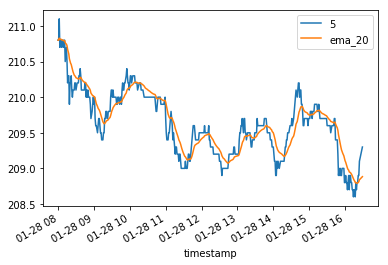

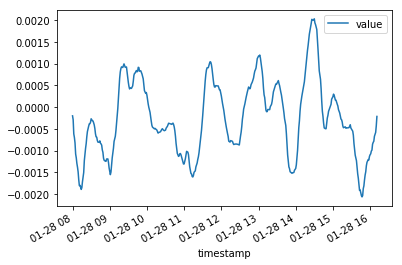

In [69]:
diff=time_series_all_list[2][0]['ema_20'].diff()[1:]/time_series_all_list[2][0]['ema_20']
time_series_all_list[2][0]['diff_ema_20'] = diff

In [91]:
time_series_all_list[2][0]['value'] = 0


In [121]:
time_series_all_list[2][0]['value'] = time_series_all_list[2][0]['diff_ema_20'].shift(-1) + 0.98 * time_series_all_list[2][0]['value'].shift(-1)

In [122]:
time_series_all_list[2][0]

,0,1,2,3,4,5,6,timestamp,sma_10,ema_10,ema_20,diff_ema_20,value
41886,120,2019-01-28 08:00:00+00,211.2,211.6,210.4,210.8,26000,2019-01-28 08:00:00,NaN,210.800000,210.800000,NaN,-0.000201
41887,120,2019-01-28 08:01:00+00,210.8,210.8,210.8,210.8,2,2019-01-28 08:01:00,NaN,210.800000,210.800000,0.000000e+00,-0.000290
41888,120,2019-01-28 08:02:00+00,211.0,211.1,210.7,211.1,1013,2019-01-28 08:02:00,NaN,210.854545,210.828571,1.355197e-04,-0.000616
41889,120,2019-01-28 08:03:00+00,210.8,210.9,210.7,210.7,166,2019-01-28 08:03:00,NaN,210.826446,210.816327,-5.808325e-05,-0.000698
41890,120,2019-01-28 08:04:00+00,210.8,211.0,210.8,210.8,1077,2019-01-28 08:04:00,NaN,210.821638,210.814772,-7.375706e-06,-0.000822
41891,120,2019-01-28 08:05:00+00,210.8,211.0,210.8,210.8,1836,2019-01-28 08:05:00,NaN,210.817704,210.813365,-6.673302e-06,-0.001077
41892,120,2019-01-28 08:06:00+00,211.0,211.0,210.7,210.7,1626,2019-01-28 08:06:00,NaN,210.796303,210.802568,-5.121687e-05,-0.001164
41893,120,2019-01-28 08:07:00+00,210.8,210.8,210.8,210.8,1352,2019-01-28 08:07:00,NaN,210.796975,210.802324,-1.160263e-06,-0.001293
41894,120,2019-01-28 08:08:00+00,210.7,210.8,210.6,210.8,2302,2019-01-28 08:08:00,NaN,210.797525,210.802102,-1.049763e-06,-0.001380
41895,120,2019-01-28 08:09:00+00,210.9,211.0,210.6,210.7,3588,2019-01-28 08:09:00,210.80,210.779793,210.792378,-4.613082e-05,-0.001486


In [70]:

time_series_all_list[2][0]['value_ema_20'] = 0

In [ ]:
for iter in range(10):
    